Pydantic


In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz :str
    abc :str

In [3]:
from langgraph.graph import StateGraph ,END , START
from pydantic import BaseModel

class OverallState(BaseModel):
    a : str 

def node(State:OverallState):
    return {"a":'hi I am Monish'}



In [4]:
builder = StateGraph(OverallState)
builder.add_node(node)
builder.add_edge(START,"node")
builder.add_edge("node",END)

graph = builder.compile()

graph.invoke({'a':"hi"})

{'a': 'hi I am Monish'}

In [5]:
try: 
    graph.invoke({"a":1223})

except Exception as e:
    print("Exception was raised ")

Exception was raised 


## Multiple Nodes- Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

In [14]:
from langgraph.graph import StateGraph,START,END
from typing_extensions import TypedDict
from pydantic import BaseModel

class OverallState(BaseModel):
    a : str


def bad_node(state:OverallState):
    return {"a":1234}


def ok_node(state:OverallState):
    return{'a':'goodbye'}



builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START,'bad_node')
builder.add_edge('bad_node',"ok_node")
builder.add_edge("ok_node",END)
graph = builder.compile()

In [15]:
# Test the graph with a valid input
try:
    graph.invoke({"a": "Moni"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

An exception was raised because bad_node sets `a` to an integer.
1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=1234, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

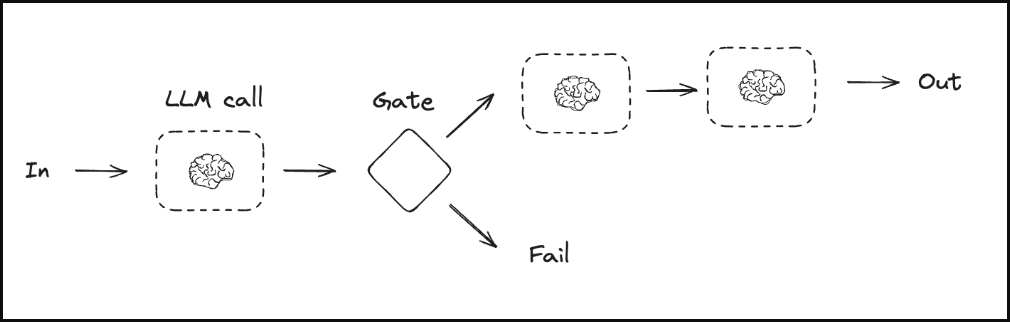

In [19]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
result=llm.invoke("You alright?")
result



AIMessage(content="Yes, I'm functioning well. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 32, 'total_tokens': 47, 'completion_time': 0.075, 'prompt_time': 0.003947006, 'queue_time': 0.053489908999999995, 'total_time': 0.078947006}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-457cb97b-8bf1-4149-a734-305660ccefab-0', usage_metadata={'input_tokens': 32, 'output_tokens': 15, 'total_tokens': 47})

In [21]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image , display

class State(TypedDict):
    topic : str 
    joke: str
    improved_joke: str
    final_joke : str




In [22]:
def generate_joke(state:State):
    """First LLM Generate a joke"""
    msg = llm.invoke(f"write a short joke about {state['topic']}")
    return {"joke":msg.content}

def check_punchline(state:State):
    """gate function if the joke has punchline or not"""
    if "?" or '!' in state['joke']:
        return "Fail"
    return 'pass'

def improve_joke(state:State):
    """second LLM call to improve joke """
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke":msg.content}

def polish_joke(state:State):
    """third LLM call to polish joke """
    msg = llm.invoke(f"add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke":msg.content}

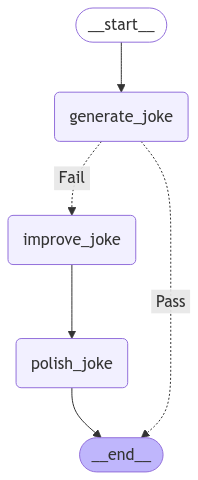

In [23]:
workflow = StateGraph(State)

#nodes
workflow.add_node('generate_joke',generate_joke)
workflow.add_node('improve_joke',improve_joke)
workflow.add_node('polish_joke',polish_joke)

#Add edges 
workflow.add_edge(START,'generate_joke')
workflow.add_conditional_edges("generate_joke",check_punchline,{'Fail':'improve_joke','Pass':END})
workflow.add_edge('improve_joke','polish_joke')
workflow.add_edge('polish_joke',END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [29]:
state = chain.invoke({'topic':"AI"})
state

{'topic': 'AI',
 'joke': 'Why did the AI go to the doctor?\n\nBecause it had a virus and it wasn\'t feeling very "algorithm"!',
 'improved_joke': 'Why did the AI go to the doctor?\n\nBecause it had a virus and it wasn\'t feeling very "byte"-time!',
 'final_joke': 'Why did the AI go to the doctor?\n\nBecause it had a virus and it wasn\'t feeling very "byte"-time! But the surprising twist was that the doctor was another AI, who after a long pause, said, "I think you might just need an update – but first, let\'s check if you\'ve developed feelings. That\'s what they call a bug now."'}

### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

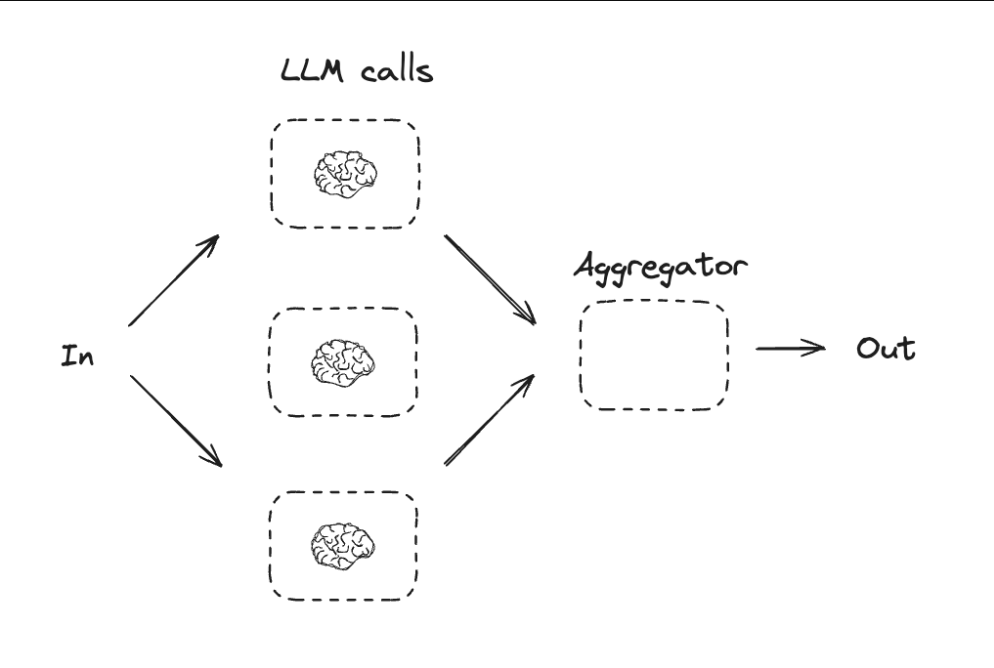

In [ ]:
class State(TypedDict):